<a href="https://colab.research.google.com/github/deepthivj-aiml/Anomaly-Detection/blob/main/anomaly_detection_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset downloaded and saved as /content/creditcard.csv
Dataset shape: (5, 32)
Columns: ['Unnamed: 0', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Heuristic anomalies: 1
Autoencoder trained.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:26:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


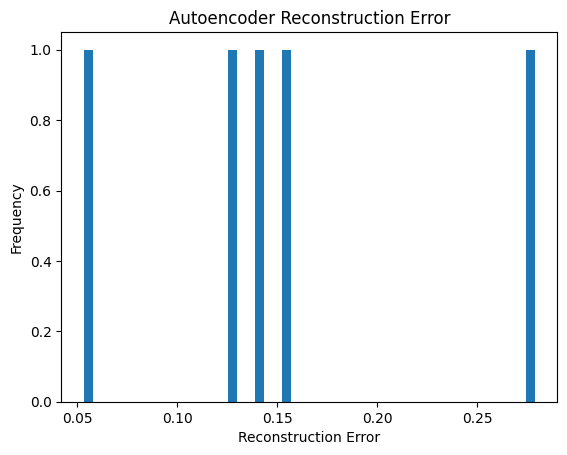

In [ ]:
# Single-cell Anomaly Detection Pipeline (public, anonymized)
!pip install --quiet scikit-learn xgboost pandas numpy matplotlib seaborn torch

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import urllib.request

# -----------------------------
# Step 0: Download public dataset
# -----------------------------
url = "https://gist.githubusercontent.com/MohammedAzarudeenBilal/820ffb6cdc19bde65e334845ce7dcf61/raw/credit%20card%20fraud%20detection%20dataset.csv"
file_path = "/content/creditcard.csv"
if not os.path.exists(file_path):
    urllib.request.urlretrieve(url, file_path)
print("Dataset downloaded and saved as", file_path)

# Load dataset (all rows)
df = pd.read_csv(file_path)
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# -----------------------------
# Step 1: Heuristic Pseudo-Labels
# -----------------------------
df['heuristic_label'] = ((df['Amount']>200) | (df['V1']<-3)).astype(int)
print("Heuristic anomalies:", df['heuristic_label'].sum())

# -----------------------------
# Step 2: Feature Engineering
# -----------------------------
features = ['Amount','V1','V2','V3','V4','V5','V6']
X_scaled = StandardScaler().fit_transform(df[features].fillna(0))

# -----------------------------
# Step 3: Autoencoder
# -----------------------------
class AE(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(n_features,16), nn.ReLU(), nn.Linear(16,8))
        self.decoder = nn.Sequential(nn.Linear(8,16), nn.ReLU(), nn.Linear(16,n_features))
    def forward(self,x):
        return self.decoder(self.encoder(x))

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
ae = AE(X_scaled.shape[1])
optimizer = torch.optim.Adam(ae.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(20):
    optimizer.zero_grad()
    loss = criterion(ae(X_tensor), X_tensor)
    loss.backward()
    optimizer.step()
print("Autoencoder trained.")

# Reconstruction error
with torch.no_grad():
    recon = ae(X_tensor)
    errors = torch.mean((recon - X_tensor)**2, axis=1).numpy()

df['ae_score'] = errors
df['label'] = df['heuristic_label']
df['ae_scaled'] = StandardScaler().fit_transform(df[['ae_score']])

# -----------------------------
# Step 4: Supervised Classifier
# -----------------------------
X_final = np.hstack([X_scaled, df['ae_scaled'].values.reshape(-1,1)])
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# -----------------------------
# Step 5: Evaluation
# -----------------------------
print(classification_report(y_test, y_pred))

plt.hist(df['ae_score'], bins=50)
plt.title("Autoencoder Reconstruction Error")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()


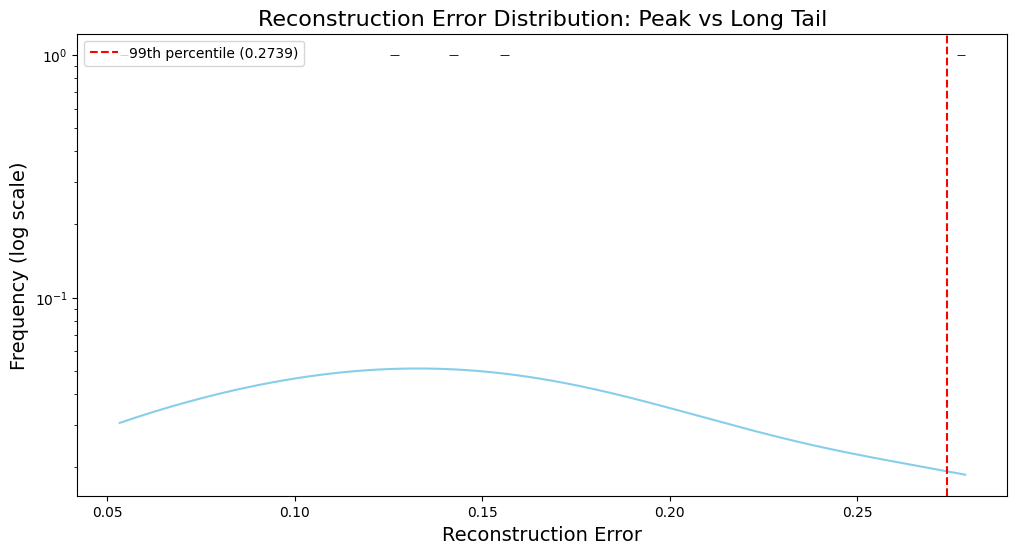

Transactions above the 99th percentile (potential anomalies): 1


In [ ]:
# -----------------------------
# Section 4: Evaluation & Visualizing the "Long Tail"
# -----------------------------

import seaborn as sns

plt.figure(figsize=(12,6))

# Plot reconstruction error distribution
sns.histplot(df['ae_score'], bins=100, kde=True, color='skyblue', log_scale=(False, True))

plt.title("Reconstruction Error Distribution: Peak vs Long Tail", fontsize=16)
plt.xlabel("Reconstruction Error", fontsize=14)
plt.ylabel("Frequency (log scale)", fontsize=14)

# Highlight the 'tail' for anomalies
tail_threshold = np.percentile(df['ae_score'], 99)  # top 1% as tail
plt.axvline(tail_threshold, color='red', linestyle='--', label=f"99th percentile ({tail_threshold:.4f})")

plt.legend()
plt.show()

print(f"Transactions above the 99th percentile (potential anomalies): {np.sum(df['ae_score'] > tail_threshold)}")
